# **Back Order Prediction**

In [1]:
#import libraries
import pandas as pd
import numpy as np
# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plot
from matplotlib import style

In [2]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_df=pd.read_csv("Training_Dataset_v2.csv")                           #Getting the Data
   

In [5]:
train_df.head()              #lets have a look at the dataset

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0,NaN,0,0,0,0,0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2,9.0,0,0,0,0,0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2,NaN,0,0,0,0,0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7,8.0,0,0,0,0,0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8,NaN,0,0,0,0,0,0.0,0.0,4.0,2.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


Column Description
sku – Random ID for the product
national_inv – Current inventory level for the part
lead_time – Transit time for product (if available)
in_transit_qty – Amount of product in transit from source
forecast_3_month – Forecast sales for the next 3 months
forecast_6_month – Forecast sales for the next 6 months
forecast_9_month – Forecast sales for the next 9 months
sales_1_month – Sales quantity for the prior 1 month time period
sales_3_month – Sales quantity for the prior 3 month time period
sales_6_month – Sales quantity for the prior 6 month time period
sales_9_month – Sales quantity for the prior 9 month time period
min_bank – Minimum recommend amount to stock
potential_issue – Source issue for part identified
pieces_past_due – Parts overdue from source
perf_6_month_avg – Source performance for prior 6 month period
perf_12_month_avg – Source performance for prior 12 month period
local_bo_qty – Amount of stock orders overdue
deck_risk – Part risk flag
oe_constraint – Part risk flag
ppap_risk – Part risk flag
stop_auto_buy – Part risk flag
rev_stop – Part risk flag
went_on_backorder – Product actually went on backorder. This is the target value.

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28889 entries, 0 to 28888
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sku                28889 non-null  int64  
 1   national_inv       28889 non-null  int64  
 2   lead_time          27086 non-null  float64
 3   in_transit_qty     28889 non-null  int64  
 4   forecast_3_month   28889 non-null  int64  
 5   forecast_6_month   28889 non-null  int64  
 6   forecast_9_month   28889 non-null  int64  
 7   sales_1_month      28889 non-null  int64  
 8   sales_3_month      28888 non-null  float64
 9   sales_6_month      28888 non-null  float64
 10  sales_9_month      28888 non-null  float64
 11  min_bank           28888 non-null  float64
 12  potential_issue    28888 non-null  object 
 13  pieces_past_due    28888 non-null  float64
 14  perf_6_month_avg   28888 non-null  float64
 15  perf_12_month_avg  28888 non-null  float64
 16  local_bo_qty       288

In [7]:
train_df.shape

(28889, 23)

In [8]:
train_df.describe(include="all")

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,2.888900e+04,2.888900e+04,27086.000000,28889.000000,2.888900e+04,2.888900e+04,2.888900e+04,28889.000000,28888.000000,2.888800e+04,2.888800e+04,28888.000000,28888,28888.000000,28888.000000,28888.000000,28888.000000,28888,28888,28888,28888,28888,28888
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28875,NaN,NaN,NaN,NaN,21958,28882,25356,27899,28876,28581
mean,1.125919e+06,8.316042e+02,7.864136,46.954619,1.896872e+02,3.750646e+02,5.481051e+02,73.902212,216.100699,4.036777e+02,6.738293e+02,69.422113,NaN,2.484250,-7.328238,-6.884367,0.711333,NaN,NaN,NaN,NaN,NaN,NaN
std,9.185403e+03,7.294562e+04,7.050308,1538.342627,6.960036e+03,1.382776e+04,1.990480e+04,2903.577815,7346.437680,1.282701e+04,2.215093e+04,2418.320586,NaN,184.899932,27.280860,26.572416,37.811181,NaN,NaN,NaN,NaN,NaN,NaN
min,1.026827e+06,-1.186000e+03,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,NaN,0.000000,-99.000000,-99.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.118741e+06,4.000000e+00,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,NaN,0.000000,0.630000,0.660000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.125963e+06,1.500000e+01,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,2.000000e+00,3.000000e+00,0.000000,NaN,0.000000,0.820000,0.810000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.133185e+06,8.100000e+01,9.000000,0.000000,4.000000e+00,1.100000e+01,2.000000e+01,4.000000,14.000000,2.900000e+01,4.500000e+01,3.000000,NaN,0.000000,0.970000,0.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


A generic question shall be: Which order could not be fulfilled by the company?

These general questions might lead you to more specific questions:

What’s the relationship between products and backorder?
How prominent is that relationship? 
Which features contribute more to backorder (company is not able to keep up with the delivery of the order)? 
Which product has high demand ?

So answer all these question, we will first visualize our data 

#** Missing Values**

First step is to check hor many missing values are present in our data.

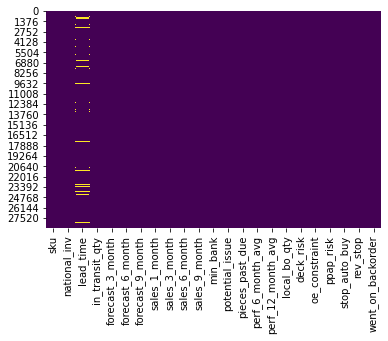

In [9]:
sns.heatmap(train_df.isnull(), cmap='viridis',cbar=False)

In [10]:
train_df.isna().sum()                       #check number of missing values

sku                     0
national_inv            0
lead_time            1803
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           1
sales_6_month           1
sales_9_month           1
min_bank                1
potential_issue         1
pieces_past_due         1
perf_6_month_avg        1
perf_12_month_avg       1
local_bo_qty            1
deck_risk               1
oe_constraint           1
ppap_risk               1
stop_auto_buy           1
rev_stop                1
went_on_backorder       1
dtype: int64

In [11]:
train_df['lead_time'].fillna(train_df['lead_time'].median(),inplace=True)          #replace missing vales in "lead_time" with its median

In [12]:
train_df.dropna(how='any',thresh=None, subset=None, inplace=True)             #drop rest null values 

In [13]:
(train_df.isna().mean())*100        #check % of missing values

sku                  0.0
national_inv         0.0
lead_time            0.0
in_transit_qty       0.0
forecast_3_month     0.0
forecast_6_month     0.0
forecast_9_month     0.0
sales_1_month        0.0
sales_3_month        0.0
sales_6_month        0.0
sales_9_month        0.0
min_bank             0.0
potential_issue      0.0
pieces_past_due      0.0
perf_6_month_avg     0.0
perf_12_month_avg    0.0
local_bo_qty         0.0
deck_risk            0.0
oe_constraint        0.0
ppap_risk            0.0
stop_auto_buy        0.0
rev_stop             0.0
went_on_backorder    0.0
dtype: float64

Now , lets see how many columns are numerical and categorical for better understanding and visualization

In [15]:
train_id=train_df['sku']
train_df.drop('sku',axis=1,inplace=True)                #drop id column

In [16]:
y=train_df['went_on_backorder']

In [17]:
Numerical_features=train_df.select_dtypes(exclude=['object'])
Numerical_features.columns

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty'],
      dtype='object')

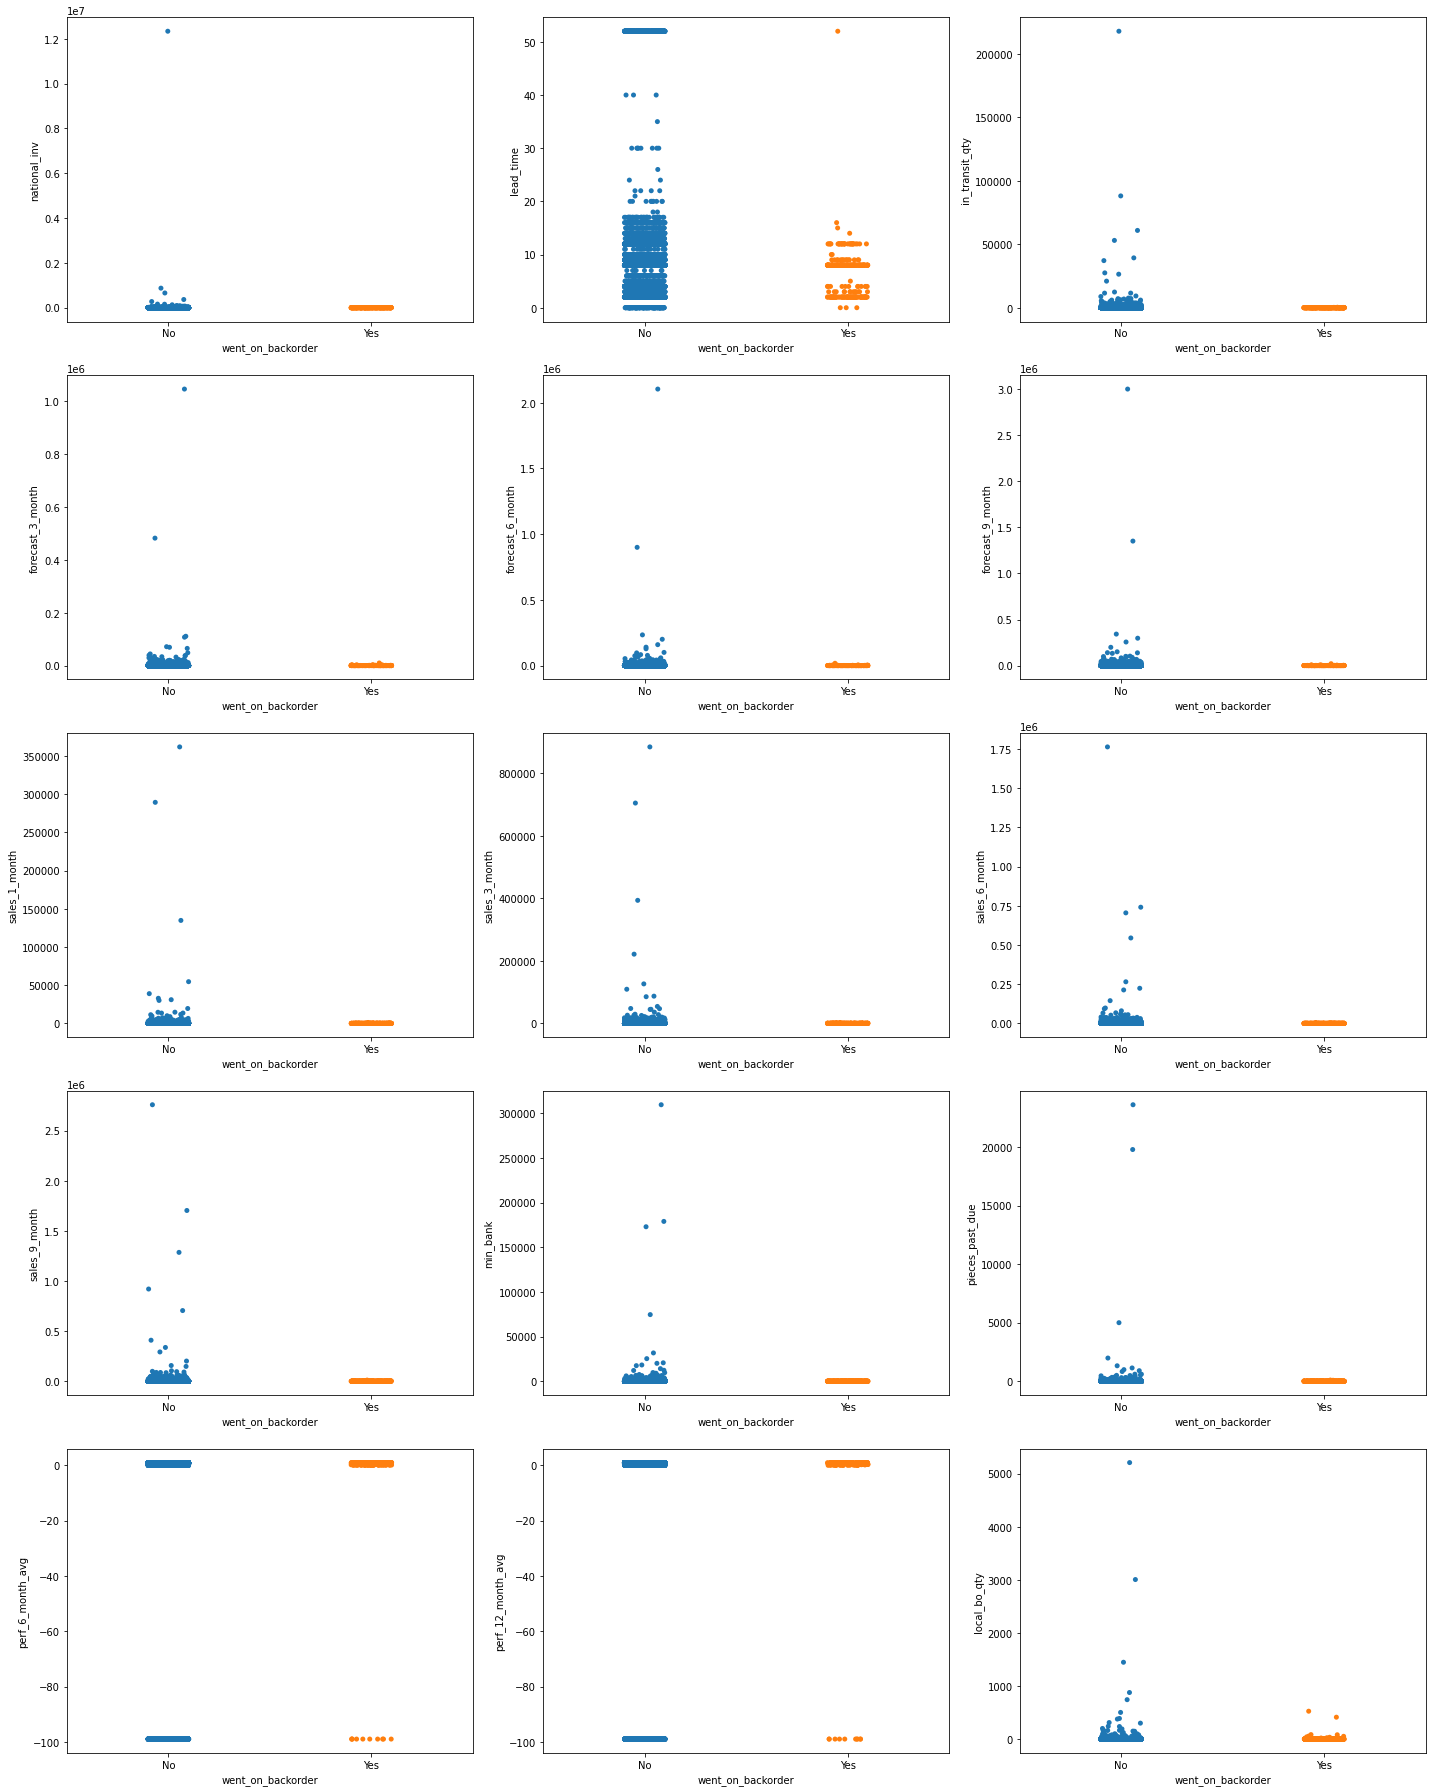

In [18]:
# let's see relationship for target col and every numerical column
plot.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in Numerical_features:
    if plotnumber<=15 :
        ax = plot.subplot(5,3,plotnumber)
        sns.stripplot(y,Numerical_features[column])
    plotnumber+=1
plot.tight_layout()

# Categorical Features

In [19]:
Categorical_features=train_df.select_dtypes(include=['object'])
Categorical_features.columns

Index(['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk',
       'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

Distribution of categorical features

In [20]:
#checking how many unique values are in columns
for col in Categorical_features.columns:
    print(len(train_df[col].unique()))

2
2
2
2
2
2
2


In [21]:
str=Categorical_features.columns

In [22]:
train_df[col].unique()

array(['No', 'Yes'], dtype=object)

In [23]:
#encoding of categorical
for col in str:
    train_df[col] = train_df[col].map({"Yes" : 0, "No" : 1})

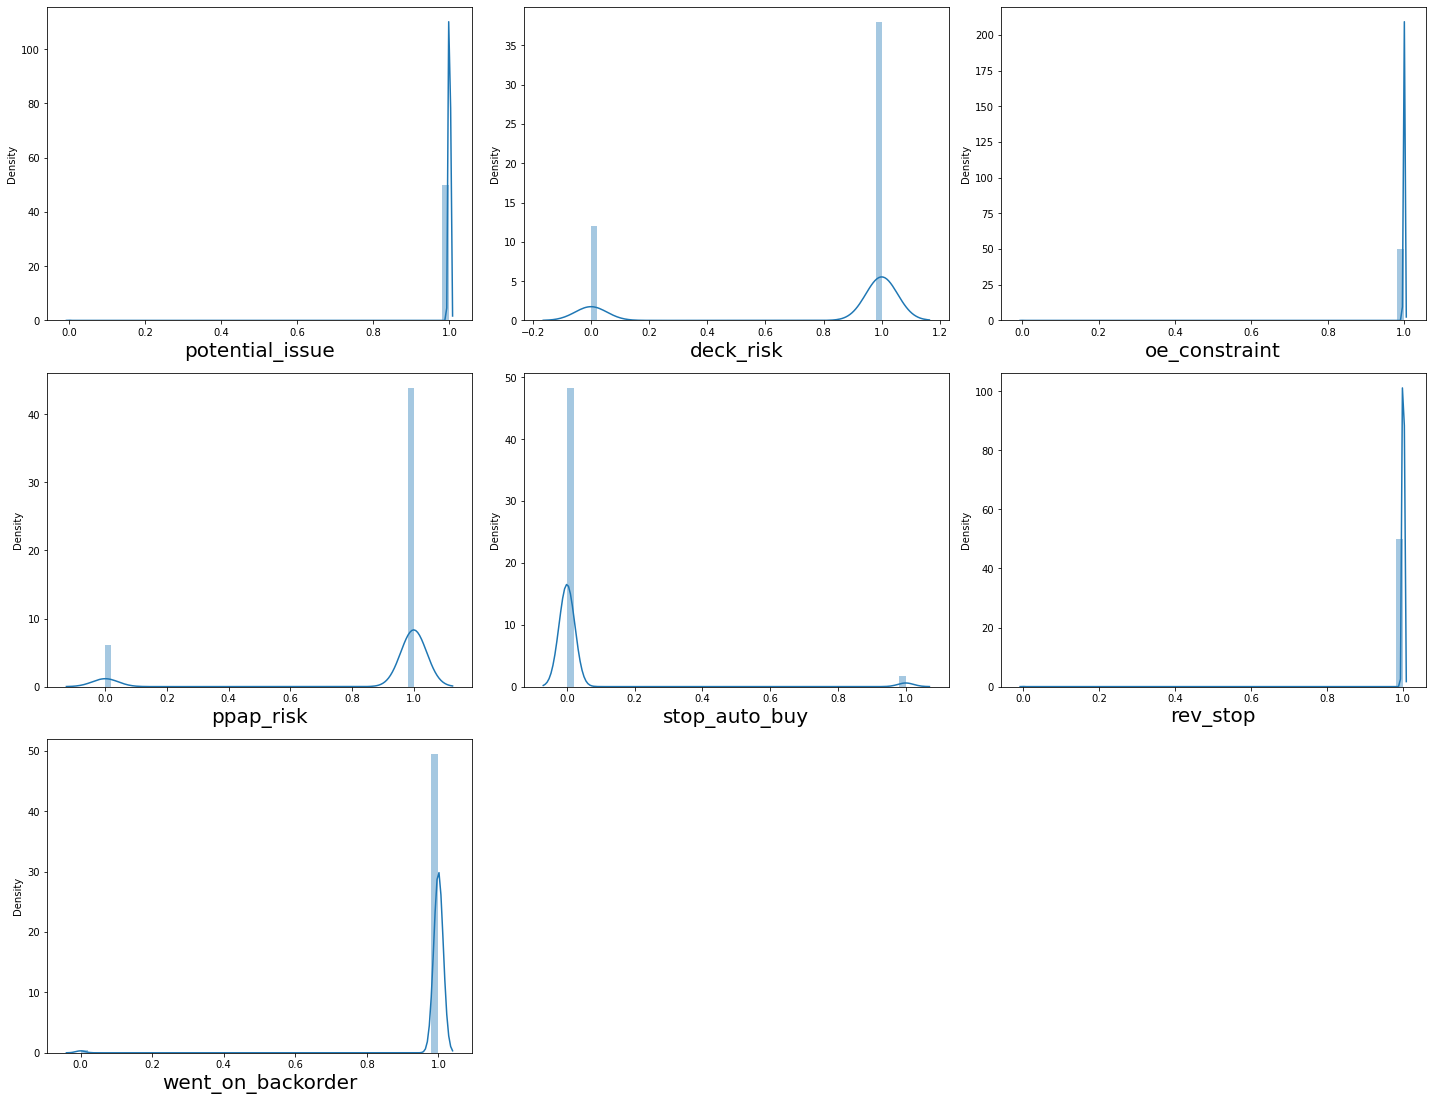

In [24]:
# let's see distributiion of categorical columns
plot.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in Categorical_features:
    if plotnumber<=15 :
        ax = plot.subplot(5,3,plotnumber)
        sns.distplot(train_df[column])
        plot.xlabel(column,fontsize=20)
    plotnumber+=1
plot.tight_layout()

In [25]:
train_df.describe(include="all")

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,2.888800e+04,28888.000000,28888.000000,2.888800e+04,2.888800e+04,2.888800e+04,28888.000000,28888.000000,2.888800e+04,2.888800e+04,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000
mean,8.316310e+02,7.872611,46.955760,1.896937e+02,3.750776e+02,5.481241e+02,73.904770,216.100699,4.036777e+02,6.738293e+02,69.422113,0.999550,2.484250,-7.328238,-6.884367,0.711333,0.760108,0.999792,0.877735,0.034236,0.999585,0.989373
std,7.294688e+04,6.826944,1538.369241,6.960156e+03,1.382800e+04,1.990514e+04,2903.628039,7346.437680,1.282701e+04,2.215093e+04,2418.320586,0.021209,184.899932,27.280860,26.572416,37.811181,0.427025,0.014411,0.327598,0.181837,0.020377,0.102541
min,-1.186000e+03,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-99.000000,-99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000e+00,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000,0.630000,0.660000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
50%,1.500000e+01,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,2.000000e+00,3.000000e+00,0.000000,1.000000,0.000000,0.820000,0.810000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,8.100000e+01,8.000000,0.000000,4.000000e+00,1.100000e+01,2.000000e+01,4.000000,14.000000,2.900000e+01,4.500000e+01,3.000000,1.000000,0.000000,0.970000,0.950000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.233440e+07,52.000000,217729.000000,1.046592e+06,2.104128e+06,3.002688e+06,361803.000000,884575.000000,1.763533e+06,2.758103e+06,309667.000000,1.000000,23616.000000,1.000000,1.000000,5208.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
train_df.isnull().sum()

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64

In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28888 entries, 0 to 28887
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   national_inv       28888 non-null  int64  
 1   lead_time          28888 non-null  float64
 2   in_transit_qty     28888 non-null  int64  
 3   forecast_3_month   28888 non-null  int64  
 4   forecast_6_month   28888 non-null  int64  
 5   forecast_9_month   28888 non-null  int64  
 6   sales_1_month      28888 non-null  int64  
 7   sales_3_month      28888 non-null  float64
 8   sales_6_month      28888 non-null  float64
 9   sales_9_month      28888 non-null  float64
 10  min_bank           28888 non-null  float64
 11  potential_issue    28888 non-null  int64  
 12  pieces_past_due    28888 non-null  float64
 13  perf_6_month_avg   28888 non-null  float64
 14  perf_12_month_avg  28888 non-null  float64
 15  local_bo_qty       28888 non-null  float64
 16  deck_risk          288

In [28]:
X = train_df.drop(["went_on_backorder"],axis=1)

In [29]:
y =train_df["went_on_backorder"]

 Let's proceed by checking multicollinearity in the dependent variables. Before that, we should scale our data. Let's use the standard scaler for that.

In [30]:
from sklearn.preprocessing import StandardScaler

In [31]:
scalar = StandardScaler()

In [32]:
X_scaled = pd.DataFrame(scalar.fit_transform(X),columns=X.columns)

X_scaled

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
0,-0.011401,0.018660,-0.030524,-0.027255,-0.027125,-0.027537,-0.025453,-0.029416,-0.031471,-0.030420,-0.028707,0.021218,-0.013436,-3.360354,-3.466649,-0.018813,0.561785,0.014413,0.373224,-0.18828,0.020386
1,-0.011373,0.165141,-0.030524,-0.027255,-0.027125,-0.027537,-0.025453,-0.029416,-0.031471,-0.030420,-0.028707,0.021218,-0.013436,0.304916,0.296341,-0.018813,0.561785,0.014413,0.373224,-0.18828,0.020386
2,-0.011373,0.018660,-0.030524,-0.027255,-0.027125,-0.027537,-0.025453,-0.029416,-0.031471,-0.030420,-0.028707,0.021218,-0.013436,-3.360354,-3.466649,-0.018813,-1.780040,0.014413,0.373224,-0.18828,0.020386
3,-0.011305,0.018660,-0.030524,-0.027255,-0.027125,-0.027537,-0.025453,-0.029416,-0.031471,-0.030420,-0.028294,0.021218,-0.013436,0.272292,0.263976,-0.018813,0.561785,0.014413,0.373224,-0.18828,0.020386
4,-0.011291,0.018660,-0.030524,-0.027255,-0.027125,-0.027537,-0.025453,-0.029416,-0.031471,-0.030240,-0.027880,0.021218,-0.013436,-3.360354,-3.466649,-0.018813,-1.780040,0.014413,0.373224,-0.18828,0.020386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28883,0.259308,0.018660,-0.030524,1.344146,1.988459,2.288387,-0.025453,-0.029416,-0.031471,-0.030420,-0.028707,0.021218,-0.013436,-3.360354,-3.466649,-0.018813,0.561785,0.014413,0.373224,-0.18828,0.020386
28884,-0.011346,-0.860226,-0.030524,-0.027255,-0.027125,-0.027537,-0.025453,-0.029416,-0.031238,-0.030104,-0.028707,0.021218,-0.013436,0.292087,0.284675,-0.018813,0.561785,0.014413,0.373224,-0.18828,0.020386
28885,-0.011360,0.604584,-0.029874,-0.027255,-0.027053,-0.027387,-0.025109,-0.029280,-0.031082,-0.030059,-0.028707,0.021218,-0.013436,0.298685,0.288815,-0.018813,0.561785,0.014413,0.373224,-0.18828,0.020386
28886,-0.011318,0.604584,-0.027273,-0.027255,-0.027125,-0.027537,-0.025109,-0.028872,-0.030380,-0.029788,-0.028707,0.021218,-0.013436,0.298685,0.288815,-0.018813,-1.780040,0.014413,0.373224,-0.18828,0.020386


In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = X_scaled.values

# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
# we do not include categorical values for mulitcollinearity as they do not provide much information as numerical ones do
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = X.columns

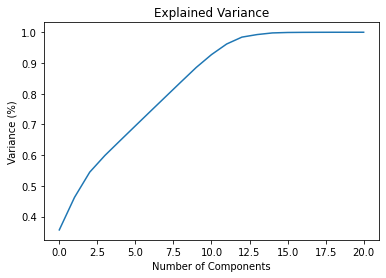

In [34]:
from sklearn.decomposition import PCA
import numpy as np
pca = PCA()
principalComponents = pca.fit_transform(X_scaled)
plot.figure()
plot.plot(np.cumsum(pca.explained_variance_ratio_))
plot.xlabel('Number of Components')
plot.ylabel('Variance (%)') #for each component
plot.title('Explained Variance')
plot.show()

In [35]:
pca = PCA(n_components=10)
new_data = pca.fit_transform(X_scaled)

principal_x = pd.DataFrame(new_data,columns=['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9','PC-10'])

In [36]:
principal_x

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10
0,-0.062846,4.037727,-0.437076,1.942977,0.163880,0.230046,0.258705,0.026143,0.044715,-0.551154
1,-0.086634,-0.595084,0.055857,-0.059903,0.156167,0.181944,0.102778,-0.001257,-0.018729,-0.298514
2,-0.078641,4.698855,-0.567305,1.503702,0.389523,-0.354658,0.248180,0.025648,0.096847,-0.395742
3,-0.085996,-0.574470,0.055036,0.067856,0.142085,0.180326,0.103945,-0.000624,-0.025721,-0.298586
4,-0.078329,4.698896,-0.566933,1.503708,0.389630,-0.354621,0.248128,0.025645,0.096847,-0.395695
...,...,...,...,...,...,...,...,...,...,...
28883,1.840505,3.847122,-2.066401,1.971888,0.347464,0.297395,0.139653,0.012263,0.032196,-0.426940
28884,-0.084240,-0.720559,0.077434,0.724789,0.055977,0.167603,0.102076,0.001617,-0.071783,-0.284394
28885,-0.086861,-0.526086,0.045301,-0.390036,0.199010,0.188180,0.103654,-0.002396,0.004226,-0.305505
28886,-0.101658,0.135170,-0.083638,-0.829381,0.423839,-0.396881,0.093434,-0.002868,0.056282,-0.150615


In [37]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,y_test = train_test_split(principal_x,y,test_size = 0.3)

In [38]:
print("Train Set Size : ",x_train.shape)
print("Train Target Set Size : ",y_train.shape)
print("Test  Set Size : ",x_test.shape)
print("Test  Target Set Size : ",y_test.shape)

Train Set Size :  (20221, 10)
Train Target Set Size :  (20221,)
Test  Set Size :  (8667, 10)
Test  Target Set Size :  (8667,)


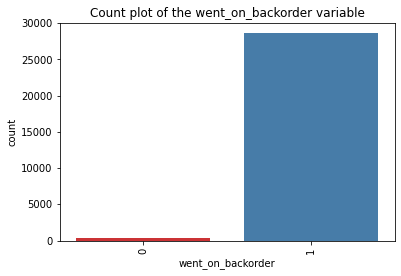

In [39]:
sns.countplot(y, palette='Set1')
plot.title("Count plot of the went_on_backorder variable")
plot.xticks(rotation = 90)
plot.show()

We can see that our dataset is imbalanced so we need to balance our dataset first

In [40]:
from imblearn.over_sampling import SMOTE

In [41]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_train, y_train = sm.fit_sample(x_train, y_train)

In [42]:
x_train.shape, y_train.shape

((40024, 10), (40024,))

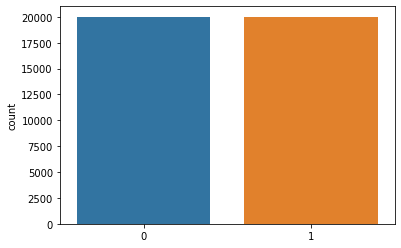

In [43]:
sns.countplot(y_train)

# **Model Building**

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV


In [45]:
#logistic Regression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
y_pred = logreg.predict(x_test)
accuracy = round(accuracy_score(y_test,y_pred)*100,2)
accuracy

53.64

In [63]:
acc_log_lr = round(logreg.score(x_train, y_train) * 100, 2)
acc_log_lr

62.46

In [48]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.02      0.63      0.03        98
           1       0.99      0.54      0.70      8569

    accuracy                           0.54      8667
   macro avg       0.50      0.58      0.36      8667
weighted avg       0.98      0.54      0.69      8667



In [49]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test,y_pred)
conf_mat

array([[  62,   36],
       [3982, 4587]])

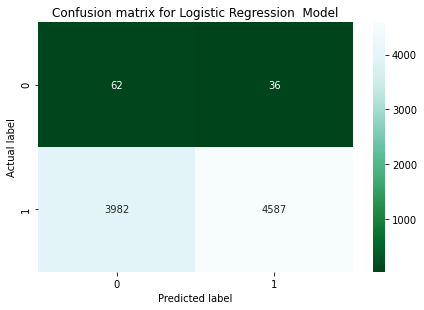

In [51]:
#create a heat map
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred)), annot = True, cmap = 'BuGn_r',
           fmt = 'g')
plot.tight_layout()
plot.title('Confusion matrix for Logistic Regression  Model', y = 1.1)
plot.ylabel('Actual label')
plot.xlabel('Predicted label')
plot.show()

**Decision Tree**

In [59]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(x_train, y_train)  

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [60]:
Y_pred = decision_tree.predict(x_test)  
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

99.99

In [64]:
acc_log_dt = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_log_dt

99.99

In [62]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.02      0.63      0.03        98
           1       0.99      0.54      0.70      8569

    accuracy                           0.54      8667
   macro avg       0.50      0.58      0.36      8667
weighted avg       0.98      0.54      0.69      8667



In [57]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test,y_pred)
conf_mat

array([[  62,   36],
       [3982, 4587]])

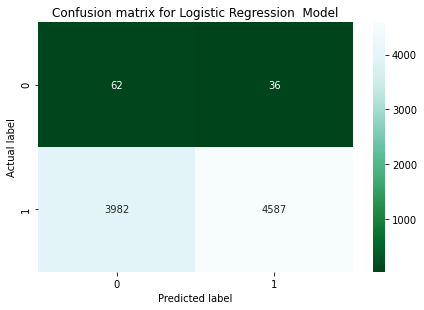

In [58]:
#create a heat map
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_pred)), annot = True, cmap = 'BuGn_r',
           fmt = 'g')
plot.tight_layout()
plot.title('Confusion matrix for Logistic Regression  Model', y = 1.1)
plot.ylabel('Actual label')
plot.xlabel('Predicted label')
plot.show()

**Random Forest**

In [67]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train, y_train)

Y_prediction = random_forest.predict(x_test)

random_forest.score(x_train, y_train)
acc_random_forest = round(random_forest.score(x_train, y_train) * 100, 2)

In [68]:
print(classification_report(y_test,y_pred))
# Confusion Matrix
conf_mat = confusion_matrix(y_test,y_pred)
print(conf_mat)

              precision    recall  f1-score   support

           0       0.02      0.63      0.03        98
           1       0.99      0.54      0.70      8569

    accuracy                           0.54      8667
   macro avg       0.50      0.58      0.36      8667
weighted avg       0.98      0.54      0.69      8667

[[  62   36]
 [3982 4587]]


In [65]:
gaussian = GaussianNB() 
gaussian.fit(x_train, y_train)  
Y_pred = gaussian.predict(x_test)  
acc_gaussian = round(gaussian.score(x_train, y_train) * 100, 2)

In [71]:
results = pd.DataFrame({
    'Model': [ 'Logistic Regression', 
              'Random Forest','Decision Tree', 'Naive Bayes',  
              ],
    'Score': [ acc_log_lr, 
              acc_random_forest, acc_log_dt,acc_gaussian]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
99.99,Random Forest
99.99,Decision Tree
62.46,Logistic Regression
53.77,Naive Bayes


In [72]:
random_forest.score(x_test,y_test)

0.9589246567439714

In [73]:
import pickle

In [74]:
# saving the model to the local file system
filename = 'backorder_model.pickle'
pickle.dump(random_forest, open(filename, 'wb'))

In [75]:
# prediction using the saved model
loaded_model = pickle.load(open(filename, 'rb'))
a=loaded_model.predict(pca.transform([[5,6,8,3,2,9,12,34,8,4,75,2,35,3,5,7,3,12,11,3,2]]))
a

array([1])